In [179]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [180]:
#read in csv
def read_csv(path, strDate, strDateFormat):
    intSuccess = 0
    if strDateFormat != '':
        df = pd.read_csv(path, delimiter=',')
        df = df.iloc[0:35]
        df[strDate] = pd.to_datetime(datetime.strptime(df[strDate]+strDateFormat), '%Y-%m-%d')
        df.set_index(strDate, drop=True, inplace=True)

    else:
        df = pd.read_csv(path,delimiter=',',parse_dates = True,
            infer_datetime_format = True,
            index_col = strDate
            )
        df.index = pd.to_datetime(df.index, format='%Y-%m')
    if df.count != 0:
        intSuccess = 1
    return df, intSuccess

             Open   High    Low  Close  Volume
Date                                          
2000-08-23  31.95  32.80  31.95  32.05   79385
2000-08-24  31.90  32.24  31.40  31.63   72978
2000-08-25  31.70  32.10  31.32  32.05   44601
2000-08-28  32.04  32.92  31.86  32.87   46770
2000-08-29  32.82  33.03  32.56  32.72   49131


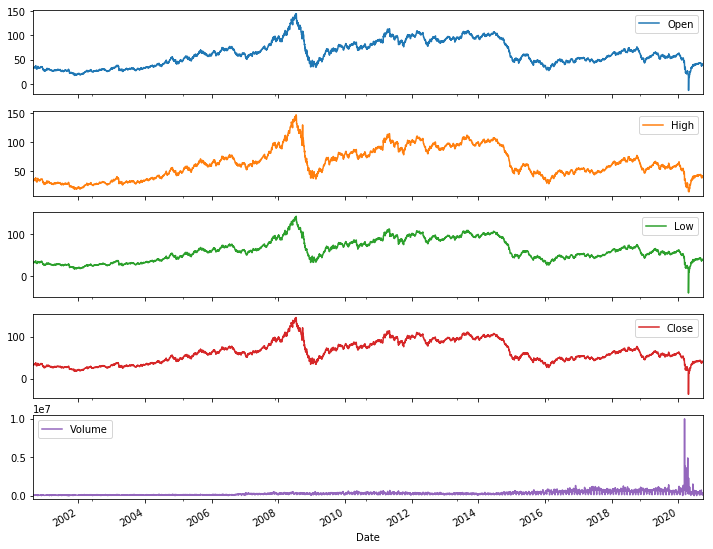

In [181]:
#read in crude price
# # print(os.path.dirname(os.getcwd()))
# base_path = os.getcwd()
# p = base_path + "\\data\\"
# print(p)
# os.chdir('')
# print(p)
strFile = 'CL=F.csv'
p = 'C:\\Users\\James McClure\\Oil_Price_Prediction\\data\\'
dfCrudePrices, intSuccess = read_csv(Path(p,strFile), 'Date', '')
if intSuccess == 1:
    print(dfCrudePrices.head())
    dfCrudePrices.plot(figsize=(12,10), subplots=True)
else:
    print('Tough luck sucker')

In [182]:
#get series with just oil prices percent change
returns = (dfCrudePrices[["Close"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
print(returns.head())
print(returns.tail())

               Close
Date                
2000-08-24 -1.310452
2000-08-25  1.327853
2000-08-28  2.558502
2000-08-29 -0.456343
2000-08-30  2.078240
               Close
Date                
2020-09-18  0.341713
2020-09-21 -4.378497
2020-09-22  0.737726
2020-09-23  0.833333
2020-09-24  0.951665


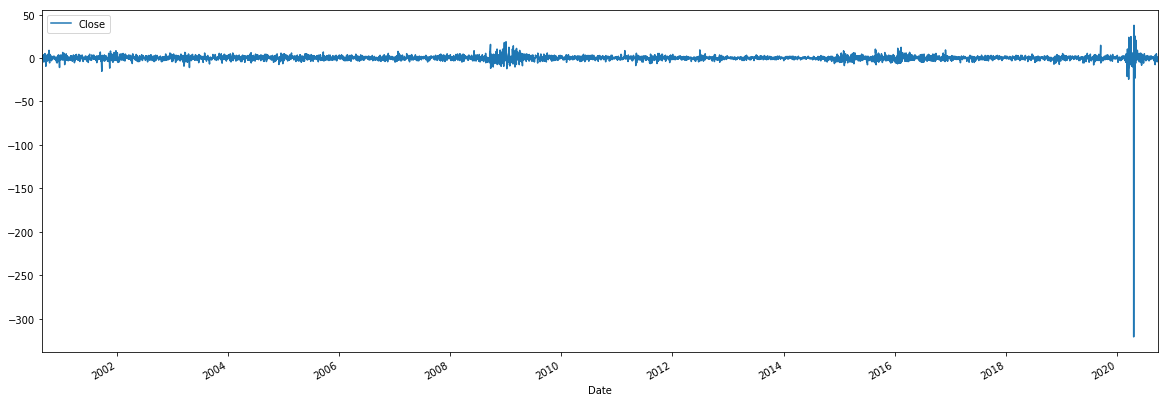

In [183]:
#plot percent price change
returns.plot(figsize=(20,7))

In [184]:
#using dicky fuller to determine if there is a statistically significant trend
from statsmodels.tsa.stattools import adfuller
print(f'Sample size = {returns.size}')
print("Augmented Dickey-Fuller")
result = adfuller(returns.Close)
print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

#interpret results
if result[0] > result[4]['1%']:
    print("adFuller indicates a trend within a 1% confidence interval.")
elif result[0] > result[4]['5%']:
    print("adFuller indicates a trend within a 5% confidence interval.")
elif result[0] > result[4]['10%']:
    print("adFuller indicates a trend within a 10% confidence interval.")
else:
    print("adFuller indicates no significant trend detected")

Sample size = 5044
Augmented Dickey-Fuller
(-14.832024971720994, 1.892884566021878e-27, 25, 5018, {'1%': -3.4316538358533277, '5%': -2.8621161549128313, '10%': -2.567076687880585}, 30859.798480721445)
ADF Statistic: -14.832025
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
adFuller indicates no significant trend detected


In [185]:
#remove data past 2020-2 to eliminate outliners massive COVID drop to see if trend is significant
remove_outliners = returns.loc['2001-09':'2020-02']

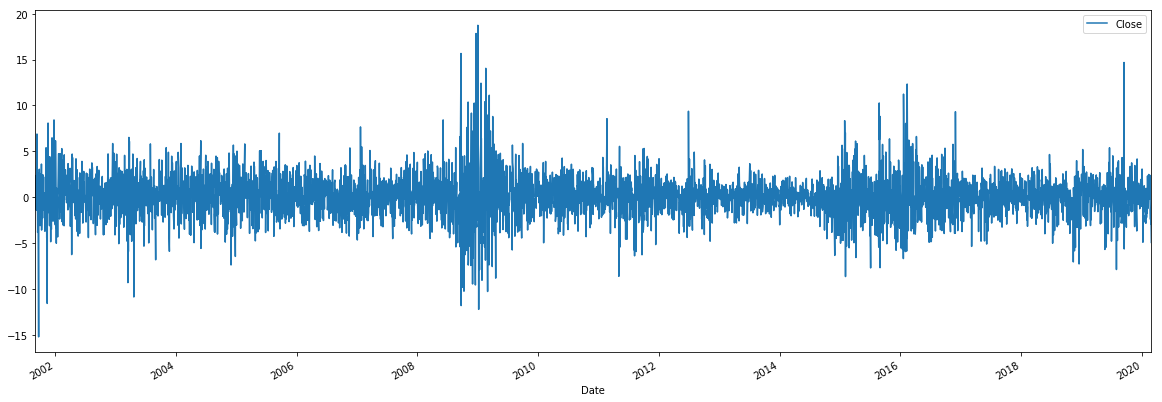

In [186]:
remove_outliners.plot(figsize=(20,7))

In [187]:
print(f'Sample size = {remove_outliners.size}')
print("Augmented Dickey-Fuller")
result = adfuller(remove_outliners.Close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
#removed data with massive drop (outlier data) to determine if the dataset was more useful without it
#interpret results
if result[0] > result[4]['1%']:
    print("adFuller indicates a trend within a 1% confidence interval.")
elif result[0] > result[4]['5%']:
    print("adFuller indicates a trend within a 5% confidence interval.")
elif result[0] > result[4]['10%']:
    print("adFuller indicates a trend within a 10% confidence interval.")
else:
    print("adFuller indicates no significant trend detected")

Sample size = 4616
Augmented Dickey-Fuller
ADF Statistic: -71.251804
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
adFuller indicates no significant trend detected


In [188]:
# from statsmodels.tsa.arima_model import ARMA
# # Estimate and ARMA model using statsmodels (use order=(2, 1))
# model = ARMA(returns.values, order=(2,1))
# result1 = model.fit()
# result1.summary()

In [189]:
# model = ARMA(remove_outliners.values, order=(2,1))
# result2 = model.fit()
# result2.summary()
# #removed data with massive drop to determine if the dataset was more useful without it

In [190]:
# pd.DataFrame(result1.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")
# pd.DataFrame(result2.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

In [191]:
#Create a random walk of the data to determine if there is a detectable trend
#Note: the following code used https://towardsdatascience.com/simulating-stock-prices-in-python-using-geometric-brownian-motion-8dfd6e8c6b18 as a guide

In [192]:
#This section will establish the shorter term random shocks reflected by standard deviation and will allow our model to randomly deviate according to our sample standard deviation

In [193]:
#Last close price of our sample
So = dfCrudePrices.last("1D")['Close'][0]
print(f'Last Close Price {So}.')

Last Close Price 40.31.


In [194]:
#instantiate our time increment
dt = 1
print(f'Time increment in Days is {dt}.')

Time increment in Days is 1.


In [195]:
#Determine days to predict as number of trading days in August
start_date = '2020-07-01'
end_date = '2020-07-31'
pred_end_date = '2020-08-31'
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
              format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
              end = pd.to_datetime(pred_end_date, 
              format = "%Y-%m-%d")).to_series(
              ).map(lambda x: 
              1 if x.isoweekday() in range(1,6) else 0).sum()
T = n_of_wkdays
print(T)

21


In [196]:
#number of time points in the time horizon
N = T / dt
print(N)

21.0


In [197]:
#time progression array
t = np.arange(1, int(N) + 1)
print(t)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [208]:
#create our sample mean
sample = returns.loc[start_date:end_date]['Close']
sample
print(sample.tolist())
mu = np.mean(returns)
print(f'The mean of July {mu[0]}')

[1.4005602240896309, 2.084379708689088, -0.6150061500615034, 0.5693069306930809, -0.02461235540242024, 0.6893156080748364, -3.1295843520782407, 2.347299343765785, -0.8138101109741003, -0.2983590253605062, 0.4738154613466383, 2.2586249689749316, -1.092233009708743, -0.39263803680981146, 0.09854644000986124, 0.44302239724340886, 2.8179367802009248, -0.14299332697808032, -1.9809069212410435, 0.5356708059410797, -0.3875030273673974, 1.1427182105518963, -1.3461538461538525, 0.56042884990255, -3.271141264841293, 0.8767535070140386]
The mean July -0.03879559941023236


In [199]:
#determine sample standard deviation
sigma = np.std(sample)
print(sigma)

1.4850517014494848


In [224]:
#create two stream of random data samples
scen_size = 2
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
print(b)

{'1': array([-0.45998416,  1.45919511, -1.06564983, -0.12932994, -0.46301502,
       -0.25978112,  1.0274846 , -0.37763823,  0.27723859,  1.06361582,
        1.44314376,  0.83599637,  0.59389715, -0.58255739,  0.03238574,
        0.68983512,  0.29888122,  0.7033301 , -3.34673871, -0.17528168,
        0.28344636]), '2': array([-0.51883087, -0.92396471, -0.589788  ,  0.30723276,  0.82660327,
        0.45642592, -1.73216944, -0.55358313,  0.07061299,  0.75604567,
       -1.88118671,  2.12899859,  0.89603849, -0.37044299,  0.62021862,
       -0.37538057, -1.72693458, -0.21036664, -0.67406444, -0.99781118,
       -0.6212308 ])}


In [201]:
#create the random walk
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}
print(W)

{'1': array([-1.08989188,  0.37104265, -0.43458181, -0.48055517, -0.16553922,
       -0.3825054 , -0.15284631, -1.27675324, -0.78307116, -2.0030269 ,
       -1.65722871, -2.57403576, -0.19015619,  1.88649235,  2.64588872,
        2.26545825,  3.63444212,  4.92721875,  5.85777832,  4.82610327,
        3.78200507]), '2': array([-1.07453845, -1.55868512,  1.12076898,  1.37715871,  1.93968476,
        2.82725032,  2.88794266,  2.2379695 ,  3.02114628,  3.28995449,
        2.01301354,  0.82774825,  1.07012144,  0.39939521,  1.03925624,
        1.72872417,  1.98354936,  4.46855963,  4.54343233,  5.24542759,
        5.43563866])}


In [202]:
#In this section we will build our Geometric Brownian Motion model building on our diffusion parameters above(short-term random nature of data)
# Up to now, we learned why we need GBM, what the parameters of a discrete-time GBM model are and how to make a prediction for 1 time point ahead

In [203]:
# Now, we build the generic closed-form equation of the Geometric Brownian Motion adjusted for discrete-time context.

In [210]:
# calculating the drift for all the time points in the prediction time horizon
drift = (mu[0] - 0.5 * sigma**2) * t
print("drift:\n", drift)

drift:
 [ -1.14148488  -2.28296975  -3.42445463  -4.56593951  -5.70742439
  -6.84890926  -7.99039414  -9.13187902 -10.2733639  -11.41484877
 -12.55633365 -13.69781853 -14.83930341 -15.98078828 -17.12227316
 -18.26375804 -19.40524292 -20.54672779 -21.68821267 -22.82969755
 -23.97118243]


In [211]:
#multiply the Brownian path(array W) with sigma
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print("diffusion:\n", diffusion)

diffusion:
 {'1': array([-1.61854579,  0.55101752, -0.64537646, -0.71364927, -0.24583431,
       -0.56804029, -0.22698468, -1.89604457, -1.16290116, -2.97459851,
       -2.46107032, -3.82257619, -0.28239177,  2.80153868,  3.92928154,
        3.36432262,  5.39733445,  7.31717459,  8.69910366,  7.16701287,
        5.61647306]), '2': array([-1.59574515, -2.31472798,  1.66439988,  2.04515188,  2.88053216,
        4.1986129 ,  4.28874416,  3.32350042,  4.48655843,  4.88575252,
        2.98942919,  1.22924895,  1.58918566,  0.59312254,  1.54334925,
        2.56724477,  2.94567335,  6.63604209,  6.74723191,  7.78973116,
        8.07220444])}


In [222]:
#below are the predictions
#second line of code adds the origin final close price so we can plot our prediction
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))
print(S)
#For some reason the array starts at 40+ but immediately drops to the values as if adding drift and diffusion only without price

[[4.03100000e+01 2.55121293e+00 7.13239686e+00 6.88505813e-01
  2.05360315e-01 1.04699691e-01 2.42254879e-02 1.08805418e-02
  6.54706174e-04 4.35217140e-04 2.27067640e-05 1.21181723e-05
  9.91749642e-07 1.09180235e-05 7.61618385e-05 7.51223802e-05
  1.36354732e-05 3.32548850e-05 7.24253905e-05 9.21116223e-05
  6.35616657e-06 4.30589866e-07]
 [4.03100000e+01 2.61005045e+00 4.06123426e-01 6.93474875e+00
  3.24077322e+00 2.38621242e+00 2.84710649e+00 9.94962331e-01
  1.21022473e-01 1.23661672e-01 5.88657012e-02 2.82201280e-03
  1.55017894e-04 7.09512053e-05 8.36824670e-06 6.91149678e-06
  6.14474266e-06 2.86492042e-06 3.66504032e-05 1.30805890e-05
  1.18478184e-05 5.01850533e-06]]


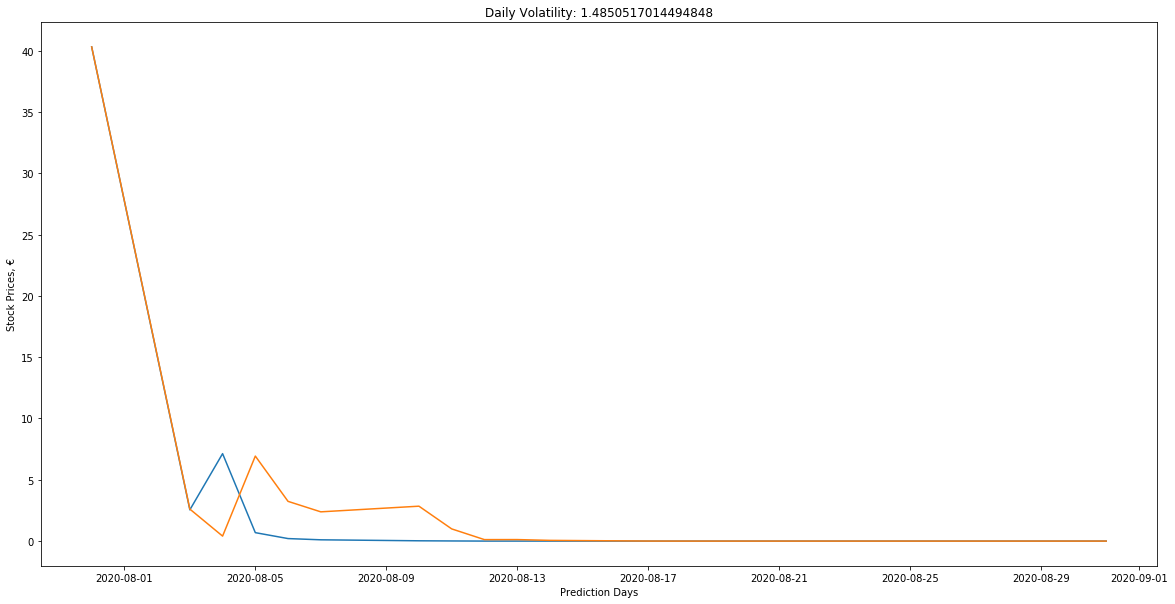

In [216]:

# Plotting the simulations
plt.figure(figsize = (20,10))

for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = sample.index.max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.ylabel('Oil Prices, $')
    plt.xlabel('Prediction Days')
    
plt.show()